In [1]:
import numpy as np
import pandas as pd
import nltk
#nltk.download()

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import string
import re

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence



In [3]:
x_train = pd.read_csv("train.csv")

y_train = np.array(pd.get_dummies(x_train.Category))
#labels = pd.factorize(x_train.Category)
x_train = x_train.drop(['Id','Category'],axis=1)

x_test = pd.read_csv("test.csv")
x_test = x_test.drop(['Id'],axis=1)


In [4]:
seqlen_train = x_train['Title'].apply(lambda x : len(x.split()))
seqlen_test = x_test['Title'].apply(lambda x : len(x.split()))

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Title', ylabel='Count'>

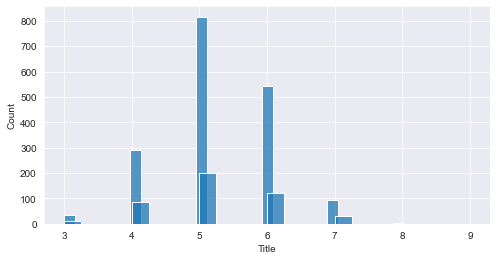

In [6]:
#看句子大概的長度範圍

sns.set_style('darkgrid')
plt.figure(figsize=(8,4))
sns.histplot(seqlen_train)
sns.histplot(seqlen_test)

text preprocessing 在transformer暫時不要做

In [7]:
x_train

,Title
0,Roddick in talks over new coach
1,Prodigy join V Festival line-up
2,Sundance to honour foreign films
3,Dunne keen to commit to Man City
4,Row over 'police' power for CSOs
...,...
1775,Lufthansa may sue over Bush visit
1776,Rolling out next generation's net
1777,Mirza makes Indian tennis history
1778,GTA sequel is criminally good


In [8]:
x_test

,Title
0,Winemaker rejects Foster's offer
1,Boeing unveils new 777 aircraft
2,Brown visits slum on Africa trip
3,US blogger fired by her airline
4,Mansfield 0-1 Leyton Orient
...,...
440,Queen recruit singer for new tour
441,Slim PlayStation triples sales
442,Vera Drake's Bafta triumph hope
443,Tindall wants second opinion


In [9]:

token = Tokenizer(num_words=6000)  

#使用Tokenizer模組建立token，建立一個字典

In [10]:
token.fit_on_texts(x_train['Title'])
token.fit_on_texts(x_test['Title'])


In [11]:
x_train_seq = token.texts_to_sequences(x_train['Title'])
x_test_seq = token.texts_to_sequences(x_test['Title'])

x_train = sequence.pad_sequences(x_train_seq,maxlen=15)
x_test = sequence.pad_sequences(x_test_seq,maxlen=15)

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


Using TensorFlow backend.


In [41]:
import os


embeddings_index = {}
#這邊需要自行下載glove檔案到本機路徑
f = open(os.path.join('C:/Users/kevin/glove.6B', 'glove.6B.300d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [42]:
word_index = token.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [43]:
'''embedding_matrix.shape'''

(4082, 300)

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="tanh"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        #self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,weights=[testembedding],
                                                                                    input_length = 15,
                                                                                     trainable=True)
        
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        x = self.token_emb(x)
        return x + positions
    
    


## HW 1.3 Transformer Model Setting

Hyperparameter of Transformer:

-Attention head 設為3

-Transformer block裡面的隱藏層的layer size設為16

-Transfromer block後面接一個 64nodes 的隱藏層，activation function 經實驗過後設為tanh表現最好

In [54]:
#設定EARLY STOP機制 監控loss變化
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1)

In [65]:

vocab_size,embed_dim = embedding_matrix.shape
maxlen = 15  # Only consider the first 200 words of each movie review
num_heads = 3  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer

testembedding = embedding_matrix.copy()

inputs = layers.Input(shape=(maxlen,))

embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)


x = layers.Dense(64 ,activation="tanh")(x)
x = layers.Dropout(0.3)(x)


outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [66]:

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])


train_history = model.fit(x_train, y_train, 
                          batch_size=32, 
                          epochs=80,
                          verbose=2,
                          callbacks=[callback],
                  #validation_split=0.1
)

Epoch 1/80
56/56 - 4s - loss: 0.6489 - accuracy: 0.7736
Epoch 2/80
56/56 - 3s - loss: 0.2413 - accuracy: 0.9275
Epoch 3/80
56/56 - 3s - loss: 0.1337 - accuracy: 0.9551
Epoch 4/80
56/56 - 3s - loss: 0.0822 - accuracy: 0.9742
Epoch 5/80
56/56 - 3s - loss: 0.0379 - accuracy: 0.9888
Epoch 6/80
56/56 - 3s - loss: 0.0164 - accuracy: 0.9972
Epoch 7/80
56/56 - 3s - loss: 0.0086 - accuracy: 0.9983
Epoch 8/80
56/56 - 3s - loss: 0.0036 - accuracy: 1.0000
Epoch 9/80
56/56 - 3s - loss: 0.0026 - accuracy: 1.0000
Epoch 10/80
56/56 - 3s - loss: 0.0022 - accuracy: 1.0000
Epoch 11/80
56/56 - 3s - loss: 0.0020 - accuracy: 1.0000
Epoch 12/80
56/56 - 3s - loss: 0.0014 - accuracy: 1.0000
Epoch 13/80
56/56 - 3s - loss: 0.0011 - accuracy: 1.0000
Epoch 14/80
56/56 - 3s - loss: 9.4609e-04 - accuracy: 1.0000
Epoch 15/80
56/56 - 3s - loss: 9.1599e-04 - accuracy: 1.0000
Epoch 16/80
56/56 - 3s - loss: 7.6867e-04 - accuracy: 1.0000
Epoch 17/80
56/56 - 3s - loss: 7.3732e-04 - accuracy: 1.0000
Epoch 18/80
56/56 - 3s -

In [67]:

y_predict = model.predict(x_test, verbose=0)

y_predict = np.argmax(y_predict,axis=1)

classes = ['business','entertainment','politics','sport','tech']

result =[]
for i in range(len(y_predict)):
    result.append([i,classes[y_predict[i]]])
    
final_result = pd.DataFrame(data=result, index=None, columns=['Id','Category'], dtype=None, copy=False)

final_result.to_csv(r'309706033_submission_transformer.csv', index = False)

In [68]:
'''model.save('transformer_model')'''

INFO:tensorflow:Assets written to: transformer_model\assets


INFO:tensorflow:Assets written to: transformer_model\assets


In [15]:
#reconstructed_model = keras.models.load_model("transformer_model")

In [16]:
'''
y_predict = reconstructed_model.predict(x_test, verbose=0)

y_predict = np.argmax(y_predict,axis=1)

classes = ['business','entertainment','politics','sport','tech']

result =[]
for i in range(len(y_predict)):
    result.append([i,classes[y_predict[i]]])
    
final_result = pd.DataFrame(data=result, index=None, columns=['Id','Category'], dtype=None, copy=False)

final_result.to_csv(r'309706033_submission_transformer.csv', index = False)'''